### Library

In [1]:
from datetime import datetime, timedelta
import oandapy
import pandas as pd
import time
import matplotlib.pyplot as plt
import mpl_finance as mpf
from matplotlib.dates import date2num
import numpy as np

### Oandaのインスタンス化

In [2]:
access_token = "c08f1f6c224577ebf30b3ae759422fc3-bd1e17d554748b04e7f37acb32dbe1da"
oanda = oandapy.API(environment="practice", access_token=access_token)

### 過去データの取得

In [3]:
#取得したい日付
end = datetime(2018, 8, 1, 0, 0)
start = end - timedelta(days = 4999)

end_day =  '{0}-{1:02d}-{2:02d}-{3:02d}:{4:02d}:{5:02d}'.format(end.year, end.month, end.day, end.hour, end.minute, end.second)
start_day =  '{0}-{1:02d}-{2:02d}-{3:02d}:{4:02d}:{5:02d}'.format(start.year, start.month, start.day, start.hour, start.minute, start.second)

res = oanda.get_history(instrument="USD_JPY",granularity="D",start = start_day, end = end_day)

In [4]:
df = pd.DataFrame(res['candles'])
df = df.drop(['complete'], axis = 1)

df['time'] = df['time'].str[:-8]
df['time'] = df['time'].str.replace('T',' ')
times = [datetime.strptime(v, '%Y-%m-%d %H:%M:%S') for v in df['time']]
df['time'] = times
df = df.set_index('time',drop = True)

### 過去データの分析

In [55]:
#移動平均の計算
window = 20
mov_ave = df.rolling(window).mean()

In [56]:
diff = mov_ave.diff()

In [57]:
mov_ave.rename(columns={'closeAsk': 'ma_closeAsk',
                            'closeBid': 'ma_closeBid',
                            'highAsk': 'ma_highAsk',
                            'highBid': 'ma_highBid',
                            'lowAsk': 'ma_lowAsk',
                            'lowBid': 'ma_lowBid',
                            'openAsk': 'ma_openAsk',
                            'openBid': 'ma_openBid',
                            'volume': 'ma_volume'
                           },inplace = True)
diff.rename(columns={'closeAsk': 'ma_diff_closeAsk',
                            'closeBid': 'ma_diff_closeBid',
                            'highAsk': 'ma_diff_highAsk',
                            'highBid': 'ma_diff_highBid',
                            'lowAsk': 'ma_diff_lowAsk',
                            'lowBid': 'ma_diff_lowBid',
                            'openAsk': 'ma_diff_openAsk',
                            'openBid': 'ma_diff_openBid',
                            'volume': 'ma_diff_volume'
                           },inplace = True)

In [58]:
df1 = df.join(mov_ave)[20:]
df2 = df1.join(diff)

In [63]:
# 閾値を設定してlong or shortの条件を得る
# 【条件1】日足全体が移動平均線の上にある
# 【条件2】日足の移動平均の変化が閾値を超える

threshold = 0.07
cond_buy = (df2['lowAsk'] > df2['ma_closeAsk']) & (df2['ma_diff_closeAsk'] > threshold)
cond_sell = (df2['highAsk'] < df2['ma_closeAsk']) & (df2['ma_diff_closeAsk'] < -1*threshold)
df2['cond_buy'] = cond_buy
df2['cond_sell'] = cond_sell

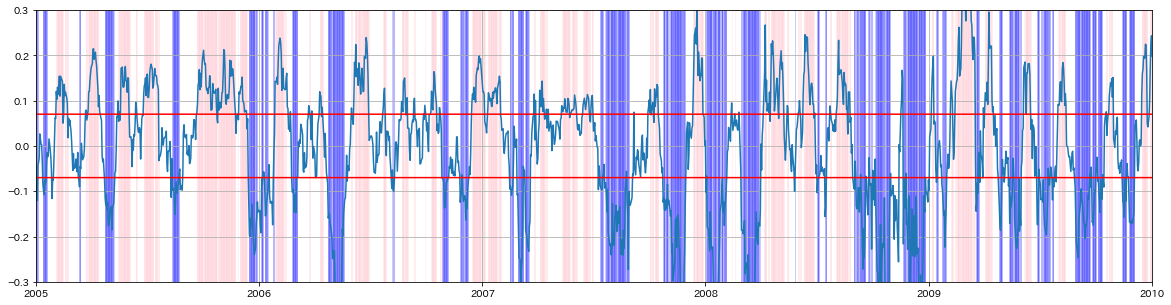

In [109]:
plt.figure(figsize = (20,5))
plt.plot(df2['ma_diff_closeAsk'])
plt.plot(df2.index, [threshold]*df2.shape[0], c = 'red')
plt.plot(df2.index, [-1*threshold]*df2.shape[0], c = 'red')
for i, v in enumerate(df2['cond_buy']):
    if v:
        plt.axvspan(df2.index[i], df2.index[i]+timedelta(days = 1), color = 'pink', alpha = 0.2)
for i, v in enumerate(df2['cond_sell']):
    if v:
        plt.axvspan(df2.index[i], df2.index[i]+timedelta(days = 1), color = 'blue', alpha = 0.2)
plt.xlim(['2005-01-01','2010-01-01'])
plt.ylim([-0.3,0.3])
plt.grid()
plt.show()

In [64]:
# long, shortの条件で売買したときの利益の計算
long = []
short = []
gets = []
for i in range(df2.shape[0]):
    if df2['cond_buy'][i]:
        print(df2.index[i], 'Buy@{}'.format(df2['openAsk'][i+1]))
        long.append(df2['openAsk'][i+1])
    elif df2['cond_sell'][i]:
        print(df2.index[i], 'Sell@{}'.format(df2['openBid'][i+1]))
        short.append(df2['openBid'][i+1])
    else:
        if len(long) != 0:
            get = len(long) * df2['openBid'][i+1] - sum(long)
            gets.append(get)
            long = []
            print(df2.index[i], 'SellBack@{}'.format(df2['openBid'][i+1]))
            print('long_get = ', get)            
        elif len(short) != 0:
            get =  sum(short) - len(short) * df2['openAsk'][i+1]
            gets.append(get)
            short = []
            print(df2.index[i], 'BuyBack@{}'.format(df2['openAsk'][i+1]))
            print('short_get = ', get)
        else:
            print(df2.index[i], 'zero_position')
print('総利益は{}'.format(sum(gets)))

2004-12-15 22:00:00 zero_position
2004-12-16 22:00:00 Buy@103.98
2004-12-18 22:00:00 Buy@104.13
2004-12-19 22:00:00 Buy@104.36
2004-12-20 22:00:00 Buy@104.25
2004-12-21 22:00:00 Buy@103.59
2004-12-22 22:00:00 SellBack@103.64
long_get =  -2.1100000000000136
2004-12-23 22:00:00 zero_position
2004-12-25 22:00:00 zero_position
2004-12-26 22:00:00 zero_position
2004-12-27 22:00:00 zero_position
2004-12-28 22:00:00 zero_position
2004-12-29 22:00:00 zero_position
2004-12-30 22:00:00 Sell@102.49
2005-01-01 22:00:00 Sell@102.66
2005-01-02 22:00:00 Sell@102.78
2005-01-03 22:00:00 BuyBack@104.57
short_get =  -5.78000000000003
2005-01-04 22:00:00 zero_position
2005-01-05 22:00:00 zero_position
2005-01-06 22:00:00 zero_position
2005-01-08 22:00:00 zero_position
2005-01-09 22:00:00 zero_position
2005-01-10 22:00:00 zero_position
2005-01-11 22:00:00 Sell@102.427
2005-01-12 22:00:00 Sell@102.37
2005-01-13 22:00:00 Sell@101.98
2005-01-14 22:00:00 Sell@101.93
2005-01-15 22:00:00 Sell@101.93
2005-01-16 2

2006-10-31 22:00:00 Sell@117.03
2006-11-01 22:00:00 Sell@117.123
2006-11-02 22:00:00 Sell@117.99
2006-11-04 22:00:00 Sell@118.03
2006-11-05 22:00:00 BuyBack@118.323
short_get =  -7.064999999999941
2006-11-06 22:00:00 zero_position
2006-11-07 22:00:00 zero_position
2006-11-08 22:00:00 zero_position
2006-11-09 22:00:00 zero_position
2006-11-11 22:00:00 zero_position
2006-11-12 22:00:00 zero_position
2006-11-13 22:00:00 zero_position
2006-11-14 22:00:00 zero_position
2006-11-15 22:00:00 zero_position
2006-11-16 22:00:00 zero_position
2006-11-18 22:00:00 zero_position
2006-11-19 22:00:00 zero_position
2006-11-20 22:00:00 zero_position
2006-11-21 22:00:00 zero_position
2006-11-22 22:00:00 zero_position
2006-11-23 22:00:00 zero_position
2006-11-24 22:00:00 zero_position
2006-11-25 22:00:00 Sell@115.525
2006-11-26 22:00:00 Sell@116.062
2006-11-27 22:00:00 Sell@116.151
2006-11-28 22:00:00 BuyBack@116.423
short_get =  -1.531000000000006
2006-11-29 22:00:00 Sell@115.795
2006-11-30 22:00:00 Sell@

2008-03-29 21:00:00 Sell@99.092
2008-03-30 21:00:00 BuyBack@99.702
short_get =  -0.6099999999999994
2008-03-31 21:00:00 zero_position
2008-04-01 21:00:00 zero_position
2008-04-02 21:00:00 zero_position
2008-04-03 21:00:00 zero_position
2008-04-05 21:00:00 Buy@101.575
2008-04-06 21:00:00 Buy@102.414
2008-04-07 21:00:00 Buy@102.68
2008-04-08 21:00:00 Buy@101.81
2008-04-09 21:00:00 SellBack@101.925
long_get =  -0.7789999999999964
2008-04-10 21:00:00 zero_position
2008-04-12 21:00:00 Buy@101.465
2008-04-13 21:00:00 SellBack@101.089
long_get =  -0.3760000000000048
2008-04-14 21:00:00 zero_position
2008-04-15 21:00:00 zero_position
2008-04-16 21:00:00 Buy@102.481
2008-04-17 21:00:00 Buy@103.732
2008-04-18 21:00:00 Buy@103.77
2008-04-19 21:00:00 Buy@103.942
2008-04-20 21:00:00 Buy@103.277
2008-04-21 21:00:00 Buy@103.037
2008-04-22 21:00:00 Buy@103.391
2008-04-23 21:00:00 Buy@104.211
2008-04-24 21:00:00 Buy@104.448
2008-04-26 21:00:00 Buy@104.512
2008-04-27 21:00:00 Buy@104.192
2008-04-28 21:0

2009-09-19 21:00:00 Sell@91.303
2009-09-20 21:00:00 BuyBack@91.931
short_get =  1.0279999999997926
2009-09-21 21:00:00 zero_position
2009-09-22 21:00:00 zero_position
2009-09-23 21:00:00 zero_position
2009-09-24 21:00:00 Sell@89.61
2009-09-25 21:00:00 Sell@89.605
2009-09-26 21:00:00 Sell@89.518
2009-09-27 21:00:00 Sell@89.625
2009-09-28 21:00:00 Sell@90.06
2009-09-29 21:00:00 Sell@89.711
2009-09-30 21:00:00 BuyBack@89.617
short_get =  0.4270000000000209
2009-10-01 21:00:00 zero_position
2009-10-02 21:00:00 zero_position
2009-10-03 21:00:00 Sell@89.334
2009-10-04 21:00:00 Sell@89.519
2009-10-05 21:00:00 Sell@88.806
2009-10-06 21:00:00 Sell@88.575
2009-10-07 21:00:00 Sell@88.381
2009-10-08 21:00:00 Sell@89.723
2009-10-09 21:00:00 Sell@89.677
2009-10-10 21:00:00 BuyBack@89.577
short_get =  -3.024000000000001
2009-10-11 21:00:00 zero_position
2009-10-12 21:00:00 zero_position
2009-10-13 21:00:00 zero_position
2009-10-14 21:00:00 zero_position
2009-10-15 21:00:00 zero_position
2009-10-16 21

2011-04-05 21:00:00 Buy@85.502
2011-04-06 21:00:00 Buy@84.925
2011-04-07 21:00:00 Buy@84.81
2011-04-08 21:00:00 Buy@84.893
2011-04-09 21:00:00 Buy@84.898
2011-04-10 21:00:00 Buy@84.603
2011-04-11 21:00:00 SellBack@83.562
long_get =  -11.8599999999999
2011-04-12 21:00:00 zero_position
2011-04-13 21:00:00 zero_position
2011-04-14 21:00:00 zero_position
2011-04-15 21:00:00 zero_position
2011-04-16 21:00:00 zero_position
2011-04-17 21:00:00 zero_position
2011-04-18 21:00:00 zero_position
2011-04-19 21:00:00 zero_position
2011-04-20 21:00:00 Sell@81.846
2011-04-21 21:00:00 Sell@81.798
2011-04-22 21:00:00 Sell@81.798
2011-04-23 21:00:00 Sell@81.773
2011-04-24 21:00:00 Sell@81.825
2011-04-25 21:00:00 Sell@81.544
2011-04-26 21:00:00 Sell@82.136
2011-04-27 21:00:00 Sell@81.522
2011-04-28 21:00:00 Sell@81.167
2011-04-29 21:00:00 Sell@81.167
2011-04-30 21:00:00 Sell@81.176
2011-05-01 21:00:00 Sell@81.217
2011-05-02 21:00:00 Sell@80.93
2011-05-03 21:00:00 Sell@80.613
2011-05-04 21:00:00 Sell@80.07

2012-12-23 22:00:00 Buy@84.781
2012-12-25 22:00:00 Buy@85.642
2012-12-26 22:00:00 Buy@86.11
2012-12-27 22:00:00 Buy@85.895
2012-12-29 22:00:00 Buy@85.834
2012-12-30 22:00:00 Buy@86.764
2013-01-01 22:00:00 Buy@87.348
2013-01-02 22:00:00 Buy@87.257
2013-01-03 22:00:00 Buy@88.17
2013-01-04 22:00:00 Buy@88.173
2013-01-05 22:00:00 Buy@88.128
2013-01-06 22:00:00 Buy@87.8
2013-01-07 22:00:00 Buy@87.061
2013-01-08 22:00:00 Buy@87.888
2013-01-09 22:00:00 Buy@88.789
2013-01-10 22:00:00 Buy@89.189
2013-01-11 22:00:00 Buy@89.294
2013-01-12 22:00:00 Buy@89.305
2013-01-13 22:00:00 Buy@89.483
2013-01-14 22:00:00 Buy@88.807
2013-01-15 22:00:00 Buy@88.397
2013-01-16 22:00:00 Buy@89.9
2013-01-17 22:00:00 Buy@90.092
2013-01-18 22:00:00 Buy@90.103
2013-01-19 22:00:00 Buy@90.107
2013-01-20 22:00:00 Buy@89.612
2013-01-21 22:00:00 SellBack@88.699
long_get =  47.09100000000035
2013-01-22 22:00:00 zero_position
2013-01-23 22:00:00 zero_position
2013-01-24 22:00:00 Buy@91.048
2013-01-26 22:00:00 Buy@91.054
2013

2015-08-12 21:00:00 zero_position
2015-08-13 21:00:00 zero_position
2015-08-16 21:00:00 zero_position
2015-08-17 21:00:00 zero_position
2015-08-18 21:00:00 zero_position
2015-08-19 21:00:00 zero_position
2015-08-20 21:00:00 Sell@121.848
2015-08-23 21:00:00 Sell@118.381
2015-08-24 21:00:00 Sell@118.841
2015-08-25 21:00:00 Sell@119.929
2015-08-26 21:00:00 Sell@121.002
2015-08-27 21:00:00 Sell@121.655
2015-08-28 21:00:00 Sell@121.6
2015-08-30 21:00:00 Sell@121.21
2015-08-31 21:00:00 Sell@119.285
2015-09-01 21:00:00 Sell@120.327
2015-09-02 21:00:00 Sell@120.049
2015-09-03 21:00:00 Sell@118.876
2015-09-06 21:00:00 Sell@119.26
2015-09-07 21:00:00 Sell@119.805
2015-09-08 21:00:00 Sell@120.453
2015-09-09 21:00:00 BuyBack@120.654
short_get =  -7.288999999999987
2015-09-10 21:00:00 zero_position
2015-09-13 21:00:00 zero_position
2015-09-14 21:00:00 zero_position
2015-09-15 21:00:00 zero_position
2015-09-16 21:00:00 zero_position
2015-09-17 21:00:00 zero_position
2015-09-20 21:00:00 zero_position

2018-02-21 22:00:00 Sell@106.727
2018-02-22 22:00:00 Sell@107.173
2018-02-25 22:00:00 Sell@106.901
2018-02-26 22:00:00 Sell@107.31
2018-02-27 22:00:00 Sell@106.644
2018-02-28 22:00:00 Sell@106.198
2018-03-01 22:00:00 Sell@105.412
2018-03-04 22:00:00 Sell@106.173
2018-03-05 22:00:00 Sell@106.109
2018-03-06 22:00:00 Sell@106.05
2018-03-07 22:00:00 Sell@106.168
2018-03-08 22:00:00 BuyBack@106.692
short_get =  10.64200000000119
2018-03-11 21:00:00 zero_position
2018-03-12 21:00:00 zero_position
2018-03-13 21:00:00 zero_position
2018-03-14 21:00:00 zero_position
2018-03-15 21:00:00 zero_position
2018-03-18 21:00:00 zero_position
2018-03-19 21:00:00 zero_position
2018-03-20 21:00:00 zero_position
2018-03-21 21:00:00 Sell@105.296
2018-03-22 21:00:00 Sell@104.62
2018-03-25 21:00:00 Sell@105.375
2018-03-26 21:00:00 Sell@105.302
2018-03-27 21:00:00 BuyBack@106.894
short_get =  -6.983000000000004
2018-03-28 21:00:00 zero_position
2018-03-29 21:00:00 zero_position
2018-04-01 21:00:00 zero_position

In [70]:
acc = 0
profits = []
for v in gets:
    acc += v
    profits.append(acc)

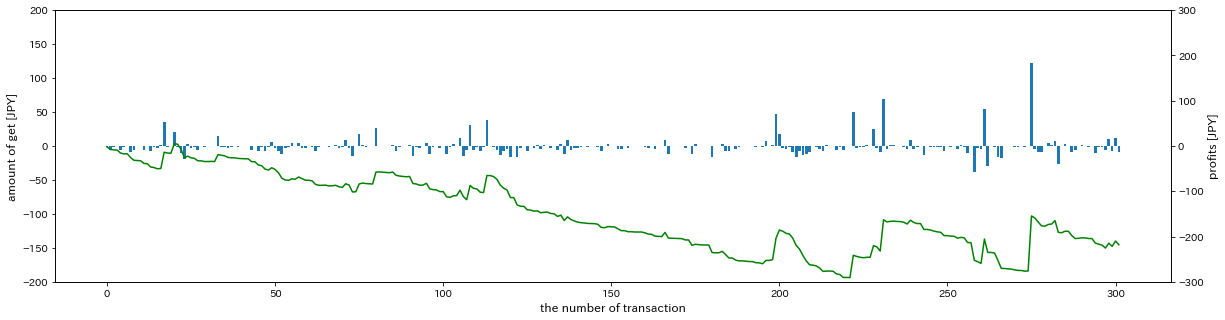

In [80]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(np.arange(len(gets)), gets)
plt.xlabel('the number of transaction', fontsize = 12)
plt.ylabel('amount of get [JPY]',fontsize = 12)
plt.ylim([-200,200])
ax2 = ax1.twinx()
ax2.plot(profits, c = 'green')
plt.ylabel('profits [JPY]',fontsize = 12)
plt.ylim([-300,300])
plt.show()

### グラフの描画

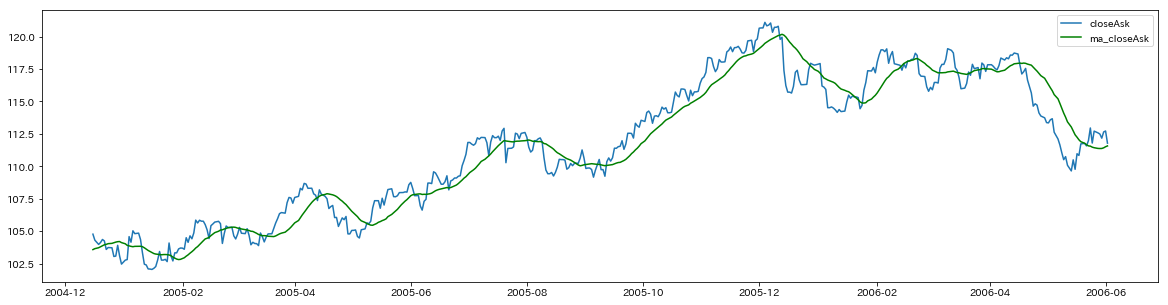

In [68]:
df3 = df2.iloc[:500,:]

fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(df3.index, df3['closeAsk'], label = 'closeAsk')
ax1.plot(df3.index, df3['ma_closeAsk'], c = 'g',label = 'ma_closeAsk')
# ax1.axvspan('2004-12-31', '2005-12-31', facecolor='r', alpha=0.5)
# ax2 = ax1.twinx()  # 2つのプロットを関連付ける
# ax2.bar(plot_data.index, plot_data['volume'], width = 1, alpha = 0.5)
# ax2.plot(df3.index, df3['roll_mean_closeAsk'], c = 'g')
plt.legend()
plt.show()